# Election Predictor

Predict Presidential Election - odds per state taken from predict-it:  
https://www.predictit.org/

This model simulaties only, if the election were held today, what are the odds that a democrat wins the Electorial College.  It doesn't take into account uncertainties due to time.

Algorithm:
For each state, use the number of electors for that state and the current odds (per predict-it) to decided if the democratic candidate wins those votes.  Run a simulation of 1000 elections and get the mean.  Do this 100 times and compute the mean, standard deviation and other statistics.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random
import numpy

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [3]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [4]:
df_orig = pd.read_csv('electorial-votes-by-state-2020.csv')
df_orig

,State,ElectVotes,Population,DWinOdds
0,California,55,39937500,93
1,Texas,38,29472300,23
2,New York,29,19440500,94
3,Florida,29,21993000,46
4,Pennsylvania,20,12820900,61
5,Illinois,20,12659700,94
6,Ohio,18,11747700,37
7,Michigan,16,10045000,71
8,Georgia,16,10736100,33
9,North Carolina,15,10611900,47


In [5]:
df_orig['votes'] = df_orig['ElectVotes'] * df_orig['DWinOdds'] /100
df_orig

,State,ElectVotes,Population,DWinOdds,votes
0,California,55,39937500,93,51.15
1,Texas,38,29472300,23,8.74
2,New York,29,19440500,94,27.26
3,Florida,29,21993000,46,13.34
4,Pennsylvania,20,12820900,61,12.20
5,Illinois,20,12659700,94,18.80
6,Ohio,18,11747700,37,6.66
7,Michigan,16,10045000,71,11.36
8,Georgia,16,10736100,33,5.28
9,North Carolina,15,10611900,47,7.05


In [6]:
sum(df_orig['votes'])

301.1700000000001

In [7]:
# Add DWin column
def DWin(row, threshold=0):
    result = 0
    if row.DWinOdds <= threshold:
        result = 0
    elif row.DWinOdds >= 100-threshold:
        result = 1
    else:
        result = random.choices([1, 0], [row.DWinOdds, 100-row.DWinOdds])[0]
    return result

Add DVotesWon Column

In [8]:
# Add DVotesWon Column
def DVotesWon(row):
    return row.ElectVotes * row.DWin

In [9]:
def sim(threshold=0):
    N = 10

    for i in range(N):
        votes = []
        df = df_orig
        df['DWin'] = df_orig.apply(DWin, threshold=threshold, axis=1)
        df['DVotesWon'] = df.apply(DVotesWon, axis=1)
        votes.append(sum(df.DVotesWon))
    return votes

In [10]:
# run the simulation 100 times
N = 1000
threshold = 0
votes = []

for i in range(N):
    print('.', end='')
    s = sim(threshold)
    mean = numpy.mean(s)
    votes.append(mean)
print()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
# percent of dem wins
votes_270 = [vote for vote in votes if vote >=270]
pct = len(votes_270) / N * 100
print('odds of dem win = {:0.1f}'.format(pct))

print('vote odds:')
for i in range(250, 425, 25):
    votes_i = [vote for vote in votes if vote >=i]
    pct = len(votes_i) / N * 100
    print('  {}: {:0.1f}'.format(i, pct))

# compute mean, variance, and standard deviation
mean = numpy.mean(votes)
var = numpy.var(votes)
std = numpy.std(votes)
print('mean = {:0.1f}'.format(mean))
print('variance = {:0.1f}'.format(var))
print('standard deviation = {:.2e}'.format(std))

odds of dem win = 79.8
vote odds:
  250: 91.9
  275: 76.7
  300: 50.1
  325: 24.7
  350: 8.6
  375: 1.9
  400: 0.0
mean = 299.9
variance = 1339.6
standard deviation = 3.66e+01


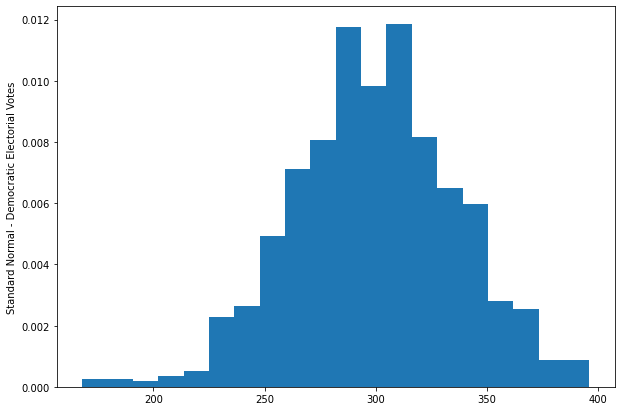

In [12]:
# plot the histogram
plt.hist(votes, density=True, bins=20)
plt.ylabel('Standard Normal - Democratic Electorial Votes');